# Discrete static gamma hedging experiment for a European Call option under the BS model
Consider a market model with two assets, a Bank account and a Stock with $P$-dynamics

$$
dB(t) = rB(t) dt, \hspace{10mm} B(0) = 1 \\
dS(t) = \mu S(t) dt + \sigma S(t) dW(t), \hspace{10mm} S(0) = s > 0
$$

In our experiment we want to hedge a portfolio composed by an European call options that at time $T$ pays $X = (S(T) - K_1)^+$ where $K_1 > 0$ is the strike price. The pricing function of this call options is denoted with $F(t, s)$.

Since we cannot gamma hedge the call options with the underlying itself (the gamma of the underlying is zero) we are going to introduce another derivative in our hedging portfolio. For this purpose I've chosen a call options that at time $T_1 > T$ pays $Y = (S(T) - K_2)$, where $K_2 > K_1$ is the strike price of this options. The pricing function of this call options is denoted with $G(t, s)$. 

The experiment will be performed with the following parameters:
$$
S(0) = 100 \\
\mu = 0.0 \\
\sigma = 0.2 \\
K_1 = 110 \\
K_2 = 120 \\
T = 1.0 \\
T_1 = 1.1 \\
r = 0.0 
$$

Furthermore, no transaction costs will be assumed.

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import numpy as np
import pandas as pd

import jax.numpy as jnp
from jax import vmap
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science','no-latex'])

from jaxfin.models.heston import UnivHestonModel
from jaxfin.price_engine.black_scholes import european_price, delta_european, gamma_european
from jaxfin.price_engine.fft import fourier_inv_call, delta_call_fourier

from src.experimental.bs_iv import IV_brent

In [3]:
seed = 0
np.random.seed(seed)

In [4]:
s0 = 100.0
v0 = 0.04
mean = 0.0
kappa = 1.0
theta = 0.04
sigma = 0.1
rho = -0.7
discount_rate = 0.0

heston_model = UnivHestonModel(s0, v0, mean, kappa, theta, sigma, rho)

In [5]:
K_1 = 100
K_2 = 110
maturity = 1.0
maturity_1 = 1.1
N = 252
dt = maturity / N
n_sim = 1000
dtype = jnp.float32

stock_paths, _ = heston_model.sample_paths(maturity, N, n_sim)

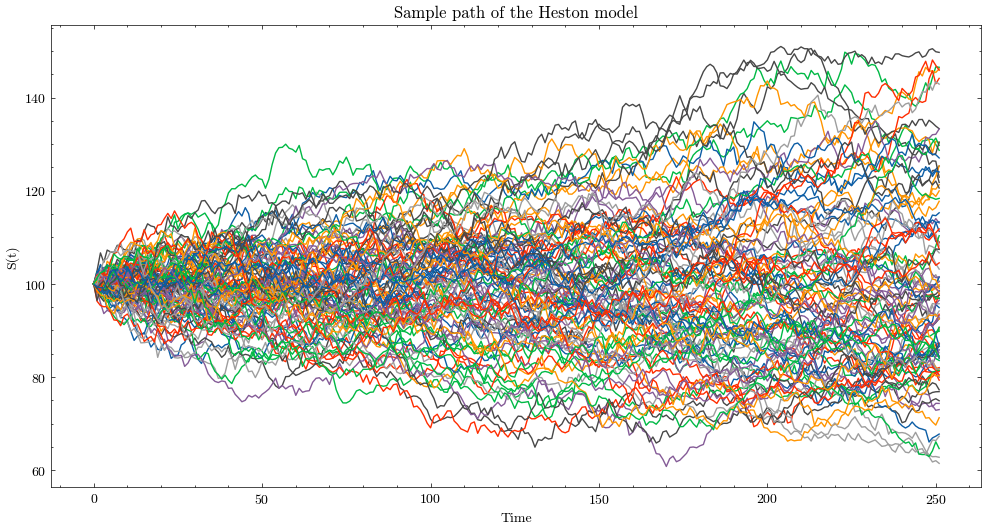

In [6]:
plt.figure(figsize=(12, 6))
plt.plot(stock_paths[:, :100])
plt.title('Sample path of the Heston model')
plt.ylabel('S(t)')
plt.xlabel('Time')
plt.show()

## Hedging experiment code

The gamma hedging will be done in the following way (Bjork, ed 4th, Cp.10.3):

With the portfolio assuming the following form:

$$
\Pi_t = - V_t * \omega S_t + \omega_1 V_t^1
$$

we have that the discrete change of the value of the portfolio is

$$
\Delta \Pi_t = - \Delta V_t + \omega \Delta S_t + \omega_1 \Delta V_t^1 + r(\omega S_t - V_t + \omega_1 V_t^1) \Delta t
$$

Since we want to minimize the variance of $\Delta \Pi_t$ with respect to $\omega$, i.e

$$
\min_{\omega} \mathbb{V}[\Delta \Pi_t] 
$$


we obtain that the optimal weights are 

- $\omega_1 = \frac{\Gamma_t^V}{\Gamma_t^{V^1}}$
- $\omega = \frac{\Delta^{V^1} \Gamma_t^V}{\Gamma_t^{V^1}} - \Delta^V$


In [7]:
v_fourier_delta_call = vmap(delta_call_fourier, in_axes=(0, None, None, None, None, None, None, None, None))
v_fourier_inv_call = vmap(fourier_inv_call, in_axes=(0, None, None, None, None, None, None, None, None))

In [8]:
def return_vs_hedging(stock_paths, K_1, K_2, discount_rate, sigma, maturity, N, ticksize):
    p_call_price = [v_fourier_inv_call(stock_paths[i], K_1, maturity - i * dt, v0, mean, theta, sigma, kappa, rho) for i in range(0, N)]
    h_call_price = [v_fourier_inv_call(stock_paths[i], K_2, maturity_1 - i * dt, v0, mean, theta, sigma, kappa, rho) for i in range(0, N)]
    iv_p = IV_brent(stock_paths[0, 0], K_1, maturity, discount_rate, np.asarray(p_call_price)[0, 0])
    iv_h = IV_brent(stock_paths[0, 0], K_2, maturity_1, discount_rate, np.asarray(h_call_price)[0, 0])

    gammas_f = gamma_european(stock_paths[0, 0], K_1, maturity, iv_p, discount_rate)
    gammas_g = gamma_european(stock_paths[0, 0], K_2, maturity_1, iv_h, discount_rate)
    x_g = gammas_f / gammas_g
    deltas_f = [v_fourier_delta_call(stock_paths[i], K_1, maturity - i * dt, v0, mean, theta, sigma, kappa, rho) for i in range(0, N)]
    deltas_g = [v_fourier_delta_call(stock_paths[i], K_2, maturity_1 - i * dt, v0, mean, theta, sigma, kappa, rho) for i in range(0, N)]
    x_s = [-((deltas_g[0] * gammas_f / gammas_g) - deltas_f[0])]
    bank_account = [p_call_price[0] - (x_g * h_call_price[0] + x_s[0] * stock_paths[0])]
    vs = [p_call_price[0]]

    for i in range(1, N):
        vs.append(x_g * h_call_price[i] + x_s[i - 1] * stock_paths[i] + bank_account[i - 1])
        x_s.append(-((deltas_g[i] * x_g) - deltas_f[i]))
        bank_account.append(vs[i] - (x_g * h_call_price[i] + x_s[i] * stock_paths[i]))

    return vs

In [9]:
vs = return_vs_hedging(stock_paths, K_1, K_2, discount_rate, sigma, maturity, N, 0.00)

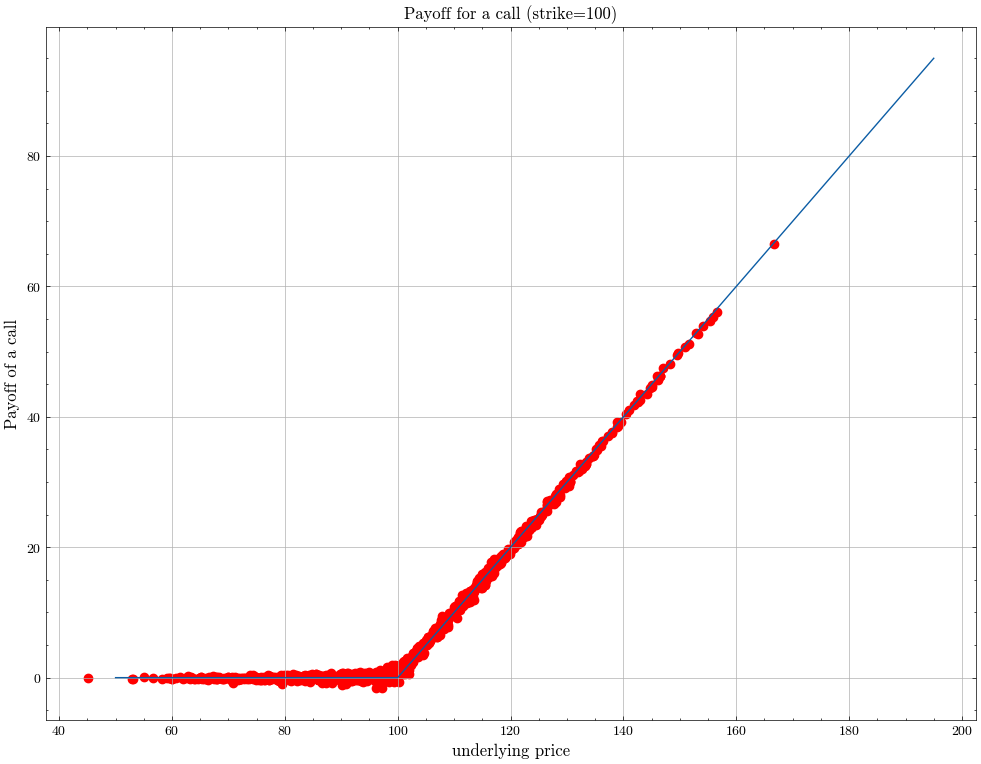

In [10]:
font = {'color':  'black',
        'weight': 'normal',
        'size': 12
       }

s = jnp.arange(50,200,5)
payoff= jnp.maximum(s - K_1, 0)
plt.figure(figsize=(12,9))
plt.plot(s,payoff)
plt.scatter(stock_paths[-1, :], jnp.asarray(vs)[-1, :], c='red')
plt.title(f"Payoff for a call (strike={K_1})", fontdict=font)
plt.xlabel("underlying price", fontdict=font)
plt.ylabel("Payoff of a call", fontdict=font)
plt.grid(True)
plt.show()

# Experiments

In [11]:
def get_transaction_costs(ticksize, ddelta):
    return ticksize * (jnp.abs(ddelta) + 0.01 * ddelta**2)

In [12]:
def hedge_experiment_loop(stock_paths, K_1, K_2, discount_rate, sigma, maturity, N, ticksize):
    p_call_price = [v_fourier_inv_call(stock_paths[i], K_1, maturity - i * dt, v0, mean, theta, sigma, kappa, rho) for i in range(0, N)]
    h_call_price = [v_fourier_inv_call(stock_paths[i], K_2, maturity_1 - i * dt, v0, mean, theta, sigma, kappa, rho) for i in range(0, N)]
    iv_p = IV_brent(stock_paths[0, 0], K_1, maturity, discount_rate, np.asarray(p_call_price)[0, 0])
    iv_h = IV_brent(stock_paths[0, 0], K_2, maturity_1, discount_rate, np.asarray(h_call_price)[0, 0])

    gammas_f = gamma_european(stock_paths[0, 0], K_1, maturity, iv_p, discount_rate)
    gammas_g = gamma_european(stock_paths[0, 0], K_2, maturity_1, iv_h, discount_rate)
    x_g = gammas_f / gammas_g
    deltas_f = np.asarray([v_fourier_delta_call(stock_paths[i], K_1, maturity - i * dt, v0, mean, theta, sigma, kappa, rho) for i in range(0, N)])
    deltas_g = np.asarray([v_fourier_delta_call(stock_paths[i], K_2, maturity_1 - i * dt, v0, mean, theta, sigma, kappa, rho) for i in range(0, N)])
    x_s = np.asarray(-((deltas_g * x_g) - deltas_f))
    bank_account = [p_call_price[0] - (x_g * h_call_price[0] + x_s[0] * stock_paths[0]) - get_transaction_costs(ticksize, x_s[0])]
    vs = [p_call_price[0]]

    for i in range(1, N):
        dw = x_s[i] - x_s[i - 1]
        transaction_costs = get_transaction_costs(ticksize, dw)
        if i == N - 1:
            transaction_costs += get_transaction_costs(ticksize, x_s[i])

        vs.append(x_g * h_call_price[i] + x_s[i - 1] * stock_paths[i] + bank_account[i - 1])
        bank_account.append(vs[i] - (x_g * h_call_price[i] + x_s[i] * stock_paths[i]) - transaction_costs)

    hedge_error = jnp.asarray(vs) - jnp.maximum(stock_paths - K_1, 0)

    return jnp.mean(hedge_error[-1]), jnp.std(hedge_error[-1]) / jnp.asarray(p_call_price)[0, 0]

In [13]:
results = {
    'Strike_1': [],
    'Strike_2': [],
    'Sigma': [],
    'Maturity': [],
    'Rebalancing_freq': [],
    'E_PL_T': [],
    'Std_PL_T': []
}

In [14]:
def update_results(stock_paths, K_1, K_2, discount_rate, sigma, maturity, N, ticksize=0.00):
    mean_hedge_error, std_hedge_error = hedge_experiment_loop(stock_paths, K_1, K_2, discount_rate, sigma, maturity, N, ticksize=ticksize)

    results['Strike_1'].append(K_1)
    results['Strike_2'].append(K_2)
    results['Sigma'].append(sigma)
    results['Maturity'].append(maturity)
    results['Rebalancing_freq'].append(N)
    results['E_PL_T'].append(mean_hedge_error)
    results['Std_PL_T'].append(std_hedge_error)

    print(f'The mean hedge error is: {mean_hedge_error}')
    print(f'The normalized std of the hedge error is: {std_hedge_error}')

    return results

## Zero transcation costs

In [15]:
ticksize = 0.0

In [16]:
results = update_results(stock_paths, K_1, K_2, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: 0.06431043893098831
The normalized std of the hedge error is: 0.06478846818208694


#### Different strike prices

$$
S_0 = 100 \quad K = 80 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 252
$$

In [17]:
K_1 = 80
sigma = 0.1
maturity = 1.0
N = 252
n_sim = 100

stock_paths, _ = heston_model.sample_paths(maturity, N, n_sim)

In [18]:
results = update_results(stock_paths, K_1, K_2, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: 0.009008522145450115
The normalized std of the hedge error is: 0.028082264587283134


$$
S_0 = 100 \quad K = 90 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 252
$$

In [19]:
K_1 = 90

stock_paths, _ = heston_model.sample_paths(maturity, N, n_sim)

In [20]:
results = update_results(stock_paths, K_1, K_2, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: 0.020783433690667152
The normalized std of the hedge error is: 0.04987521469593048


$$
S_0 = 100 \quad K = 110 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 252
$$

In [21]:
K_1 = 110

stock_paths, _ = heston_model.sample_paths(maturity, N, n_sim)

In [22]:
results = update_results(stock_paths, K_1, K_2, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: 0.0795968621969223
The normalized std of the hedge error is: 0.03743165358901024


$$
S_0 = 100 \quad K = 120 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 252
$$

In [23]:
K_1 = 120

stock_paths, _ = heston_model.sample_paths(maturity, N, n_sim)

In [24]:
results = update_results(stock_paths, K_1, K_2, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: 0.17810802161693573
The normalized std of the hedge error is: 0.2614136338233948


#### Different maturities with daily rebalancing

$$
S_0 = 100 \quad K = 100 \quad \sigma = 0.2 \quad T = 0.75 \quad n = 252
$$

In [25]:
K_1 = 100
T = 0.75
N = 252

stock_paths, _ = heston_model.sample_paths(maturity, N, n_sim)

In [26]:
results = update_results(stock_paths, K_1, K_2, discount_rate, sigma, T, N, ticksize=ticksize)

C:\Users\paolo\AppData\Local\Temp\ipykernel_1700\3978717260.py:2: RuntimeWarning: overflow encountered in square
  return ticksize * (jnp.abs(ddelta) + 0.01 * ddelta**2)


The mean hedge error is: nan
The normalized std of the hedge error is: nan


$$
S_0 = 100 \quad K = 100 \quad \sigma = 0.2 \quad T = 1.25 \quad n = 252
$$

In [27]:
T = 1.25

stock_paths, _ = heston_model.sample_paths(maturity, N, n_sim)

In [28]:
results = update_results(stock_paths, K_1, K_2, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: 0.7570457458496094
The normalized std of the hedge error is: 0.11968548595905304


$$
S_0 = 100 \quad K = 100 \quad \sigma = 0.2 \quad T = 2.00 \quad n = 252
$$

In [29]:
T = 2.0

stock_paths, _ = heston_model.sample_paths(maturity, N, n_sim)

In [30]:
results = update_results(stock_paths, K_1, K_2, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: 3.4209704399108887
The normalized std of the hedge error is: 0.22331573069095612


#### Different volatilities

$$
S_0 = 100 \quad K = 100 \quad \sigma = 0.1 \quad T = 1.0 \quad n = 252
$$

In [31]:
K_1 = 100
T = 1.0
N = 252
sigma = 0.2

heston_model = UnivHestonModel(s0, v0, mean, kappa, theta, sigma, rho)
stock_paths, _ = heston_model.sample_paths(maturity, N, n_sim)

In [32]:
results = update_results(stock_paths, K_1, K_2, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: 0.12158092856407166
The normalized std of the hedge error is: 0.1044338047504425


### Different Rebalancing periods

$$
S_0 = 100 \quad K = 100 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 52
$$

In [33]:
K_1 = 100
sigma = 0.1
N = 52
T = 1.0

heston_model = UnivHestonModel(s0, v0, mean, kappa, theta, sigma, rho)
stock_paths, _ = heston_model.sample_paths(maturity, N, n_sim)

In [34]:
results = update_results(stock_paths, K_1, K_2, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: 3.332308769226074
The normalized std of the hedge error is: 0.2694069743156433


$$
S_0 = 100 \quad K = 100 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 121
$$

In [35]:
N = 121
T = 1.0

stock_paths, _ = heston_model.sample_paths(maturity, N, n_sim)

In [36]:
results = update_results(stock_paths, K_1, K_2, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: 2.081972360610962
The normalized std of the hedge error is: 0.24061152338981628


$$
S_0 = 100 \quad K = 100 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 504
$$

In [37]:
N = 504
T = 1.0

stock_paths, _ = heston_model.sample_paths(maturity, N, n_sim)

In [38]:
results = update_results(stock_paths, K_1, K_2, discount_rate, sigma, T, N, ticksize=ticksize)

C:\Users\paolo\AppData\Local\Temp\ipykernel_1700\3978717260.py:2: RuntimeWarning: overflow encountered in square
  return ticksize * (jnp.abs(ddelta) + 0.01 * ddelta**2)


The mean hedge error is: nan
The normalized std of the hedge error is: nan


In [39]:
res_df = pd.DataFrame.from_dict(results)
res_df

,Strike_1,Strike_2,Sigma,Maturity,Rebalancing_freq,E_PL_T,Std_PL_T
0,100,110,0.1,1.00,252,0.06431044,0.06478847
1,80,110,0.1,1.00,252,0.009008522,0.028082265
2,90,110,0.1,1.00,252,0.020783434,0.049875215
3,110,110,0.1,1.00,252,0.07959686,0.037431654
4,120,110,0.1,1.00,252,0.17810802,0.26141363
5,100,110,0.1,0.75,252,nan,nan
6,100,110,0.1,1.25,252,0.75704575,0.119685486
7,100,110,0.1,2.00,252,3.4209704,0.22331573
8,100,110,0.2,1.00,252,0.12158093,0.104433805
9,100,110,0.1,1.00,52,3.3323088,0.26940697


In [40]:
res_df.to_csv('./results/heston_static_hedging_zero.csv')

## Low transcation costs

In [41]:
ticksize = 0.01
K_1 = 100
K_2 = 110
sigma = 0.1
maturity = 1.0
N = 252
n_sim = 100

heston_model = UnivHestonModel(s0, v0, mean, kappa, theta, sigma, rho)
stock_paths, _ = heston_model.sample_paths(maturity, N, n_sim)

In [42]:
results = {
    'Strike_1': [],
    'Strike_2': [],
    'Sigma': [],
    'Maturity': [],
    'Rebalancing_freq': [],
    'E_PL_T': [],
    'Std_PL_T': []
}

In [43]:
results = update_results(stock_paths, K_1, K_2, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: 0.12627658247947693
The normalized std of the hedge error is: 0.05355602875351906


#### Different strike prices

$$
S_0 = 100 \quad K = 80 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 252
$$

In [44]:
K_1 = 80
sigma = 0.1
maturity = 1.0
N = 252
n_sim = 100

stock_paths, _ = heston_model.sample_paths(maturity, N, n_sim)

In [45]:
results = update_results(stock_paths, K_1, K_2, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: 0.021698683500289917
The normalized std of the hedge error is: 0.028427038341760635


$$
S_0 = 100 \quad K = 90 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 252
$$

In [46]:
K_1 = 90

stock_paths, _ = heston_model.sample_paths(maturity, N, n_sim)

In [47]:
results = update_results(stock_paths, K_1, K_2, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: 0.011785635724663734
The normalized std of the hedge error is: 0.050212930887937546


$$
S_0 = 100 \quad K = 110 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 252
$$

In [48]:
K_1 = 110

stock_paths, _ = heston_model.sample_paths(maturity, N, n_sim)

In [49]:
results = update_results(stock_paths, K_1, K_2, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: 0.04435202479362488
The normalized std of the hedge error is: 0.047849275171756744


$$
S_0 = 100 \quad K = 120 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 252
$$

In [50]:
K_1 = 120

stock_paths, _ = heston_model.sample_paths(maturity, N, n_sim)

In [51]:
results = update_results(stock_paths, K_1, K_2, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -0.0158244501799345
The normalized std of the hedge error is: 0.23133094608783722


#### Different maturities with daily rebalancing

$$
S_0 = 100 \quad K = 100 \quad \sigma = 0.2 \quad T = 0.75 \quad n = 252
$$

In [52]:
K_1 = 100
T = 0.75
N = 252

stock_paths, _ = heston_model.sample_paths(maturity, N, n_sim)

In [53]:
results = update_results(stock_paths, K_1, K_2, discount_rate, sigma, T, N, ticksize=ticksize)

C:\Users\paolo\AppData\Local\Temp\ipykernel_1700\3978717260.py:2: RuntimeWarning: overflow encountered in square
  return ticksize * (jnp.abs(ddelta) + 0.01 * ddelta**2)


The mean hedge error is: nan
The normalized std of the hedge error is: nan


$$
S_0 = 100 \quad K = 100 \quad \sigma = 0.2 \quad T = 1.25 \quad n = 252
$$

In [54]:
T = 1.25

stock_paths, _ = heston_model.sample_paths(maturity, N, n_sim)

In [55]:
results = update_results(stock_paths, K_1, K_2, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: 0.8557052612304688
The normalized std of the hedge error is: 0.1451631337404251


$$
S_0 = 100 \quad K = 100 \quad \sigma = 0.2 \quad T = 2.00 \quad n = 252
$$

In [56]:
T = 2.0

stock_paths, _ = heston_model.sample_paths(maturity, N, n_sim)

In [57]:
results = update_results(stock_paths, K_1, K_2, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: 3.5810375213623047
The normalized std of the hedge error is: 0.22172796726226807


#### Different volatilities

$$
S_0 = 100 \quad K = 100 \quad \sigma = 0.1 \quad T = 1.0 \quad n = 252
$$

In [58]:
K_1 = 100
T = 1.0
N = 252
sigma = 0.2

heston_model = UnivHestonModel(s0, v0, mean, kappa, theta, sigma, rho)
stock_paths, _ = heston_model.sample_paths(maturity, N, n_sim)

In [59]:
results = update_results(stock_paths, K_1, K_2, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: 0.09798742085695267
The normalized std of the hedge error is: 0.12374433875083923


### Different Rebalancing periods

$$
S_0 = 100 \quad K = 100 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 52
$$

In [60]:
K_1 = 100
sigma = 0.1
N = 52
T = 1.0

heston_model = UnivHestonModel(s0, v0, mean, kappa, theta, sigma, rho)
stock_paths, _ = heston_model.sample_paths(maturity, N, n_sim)

In [61]:
results = update_results(stock_paths, K_1, K_2, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: 3.0076963901519775
The normalized std of the hedge error is: 0.2926005721092224


$$
S_0 = 100 \quad K = 100 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 121
$$

In [62]:
N = 121
T = 1.0

stock_paths, _ = heston_model.sample_paths(maturity, N, n_sim)

In [63]:
results = update_results(stock_paths, K_1, K_2, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: 1.9106603860855103
The normalized std of the hedge error is: 0.2305644452571869


$$
S_0 = 100 \quad K = 100 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 504
$$

In [64]:
N = 504
T = 1.0

stock_paths, _ = heston_model.sample_paths(maturity, N, n_sim)

In [65]:
results = update_results(stock_paths, K_1, K_2, discount_rate, sigma, T, N, ticksize=ticksize)

C:\Users\paolo\AppData\Local\Temp\ipykernel_1700\3978717260.py:2: RuntimeWarning: overflow encountered in square
  return ticksize * (jnp.abs(ddelta) + 0.01 * ddelta**2)


The mean hedge error is: nan
The normalized std of the hedge error is: nan


In [66]:
res_df = pd.DataFrame.from_dict(results)
res_df

,Strike_1,Strike_2,Sigma,Maturity,Rebalancing_freq,E_PL_T,Std_PL_T
0,100,110,0.1,1.00,252,0.12627658,0.05355603
1,80,110,0.1,1.00,252,0.021698684,0.028427038
2,90,110,0.1,1.00,252,0.011785636,0.05021293
3,110,110,0.1,1.00,252,0.044352025,0.047849275
4,120,110,0.1,1.00,252,-0.01582445,0.23133095
5,100,110,0.1,0.75,252,nan,nan
6,100,110,0.1,1.25,252,0.85570526,0.14516313
7,100,110,0.1,2.00,252,3.5810375,0.22172797
8,100,110,0.2,1.00,252,0.09798742,0.12374434
9,100,110,0.1,1.00,52,3.0076964,0.29260057


In [67]:
res_df.to_csv('./results/heston_static_hedging_low.csv')

## High transcation costs

In [68]:
ticksize = 0.05
K_1 = 100
K_2 = 110
sigma = 0.1
maturity = 1.0
N = 252
n_sim = 100

heston_model = UnivHestonModel(s0, v0, mean, kappa, theta, sigma, rho)
stock_paths, _ = heston_model.sample_paths(maturity, N, n_sim)

In [69]:
results = {
    'Strike_1': [],
    'Strike_2': [],
    'Sigma': [],
    'Maturity': [],
    'Rebalancing_freq': [],
    'E_PL_T': [],
    'Std_PL_T': []
}

In [70]:
results = update_results(stock_paths, K_1, K_2, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: 0.0031042885966598988
The normalized std of the hedge error is: 0.06555292755365372


#### Different strike prices

$$
S_0 = 100 \quad K = 80 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 252
$$

In [71]:
K_1 = 80
sigma = 0.1
maturity = 1.0
N = 252
n_sim = 100

stock_paths, _ = heston_model.sample_paths(maturity, N, n_sim)

In [72]:
results = update_results(stock_paths, K_1, K_2, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -0.1321047693490982
The normalized std of the hedge error is: 0.03104972094297409


$$
S_0 = 100 \quad K = 90 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 252
$$

In [73]:
K_1 = 90

stock_paths, _ = heston_model.sample_paths(maturity, N, n_sim)

In [74]:
results = update_results(stock_paths, K_1, K_2, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -0.13150741159915924
The normalized std of the hedge error is: 0.05393565073609352


$$
S_0 = 100 \quad K = 110 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 252
$$

In [75]:
K_1 = 110

stock_paths, _ = heston_model.sample_paths(maturity, N, n_sim)

In [76]:
results = update_results(stock_paths, K_1, K_2, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: 0.03815414011478424
The normalized std of the hedge error is: 0.04075624793767929


$$
S_0 = 100 \quad K = 120 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 252
$$

In [77]:
K_1 = 120

stock_paths, _ = heston_model.sample_paths(maturity, N, n_sim)

In [78]:
results = update_results(stock_paths, K_1, K_2, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: 0.009184506721794605
The normalized std of the hedge error is: 0.22592505812644958


#### Different maturities with daily rebalancing

$$
S_0 = 100 \quad K = 100 \quad \sigma = 0.2 \quad T = 0.75 \quad n = 252
$$

In [79]:
K_1 = 100
T = 0.75
N = 252

stock_paths, _ = heston_model.sample_paths(maturity, N, n_sim)

In [80]:
results = update_results(stock_paths, K_1, K_2, discount_rate, sigma, T, N, ticksize=ticksize)

C:\Users\paolo\AppData\Local\Temp\ipykernel_1700\3978717260.py:2: RuntimeWarning: overflow encountered in square
  return ticksize * (jnp.abs(ddelta) + 0.01 * ddelta**2)


The mean hedge error is: nan
The normalized std of the hedge error is: nan


$$
S_0 = 100 \quad K = 100 \quad \sigma = 0.2 \quad T = 1.25 \quad n = 252
$$

In [81]:
T = 1.25

stock_paths, _ = heston_model.sample_paths(maturity, N, n_sim)

In [82]:
results = update_results(stock_paths, K_1, K_2, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: 0.8222732543945312
The normalized std of the hedge error is: 0.1473831832408905


$$
S_0 = 100 \quad K = 100 \quad \sigma = 0.2 \quad T = 2.00 \quad n = 252
$$

In [83]:
T = 2.0

stock_paths, _ = heston_model.sample_paths(maturity, N, n_sim)

In [84]:
results = update_results(stock_paths, K_1, K_2, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: 3.4517643451690674
The normalized std of the hedge error is: 0.22717969119548798


#### Different volatilities

$$
S_0 = 100 \quad K = 100 \quad \sigma = 0.1 \quad T = 1.0 \quad n = 252
$$

In [85]:
K_1 = 100
T = 1.0
N = 252
sigma = 0.2

heston_model = UnivHestonModel(s0, v0, mean, kappa, theta, sigma, rho)
stock_paths, _ = heston_model.sample_paths(maturity, N, n_sim)

In [86]:
results = update_results(stock_paths, K_1, K_2, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: 0.08669600635766983
The normalized std of the hedge error is: 0.10601583868265152


### Different Rebalancing periods

$$
S_0 = 100 \quad K = 100 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 52
$$

In [87]:
K_1 = 100
sigma = 0.1
N = 52
T = 1.0

heston_model = UnivHestonModel(s0, v0, mean, kappa, theta, sigma, rho)
stock_paths, _ = heston_model.sample_paths(maturity, N, n_sim)

In [88]:
results = update_results(stock_paths, K_1, K_2, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: 3.0730974674224854
The normalized std of the hedge error is: 0.2848048806190491


$$
S_0 = 100 \quad K = 100 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 121
$$

In [89]:
N = 121
T = 1.0

stock_paths, _ = heston_model.sample_paths(maturity, N, n_sim)

In [90]:
results = update_results(stock_paths, K_1, K_2, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: 1.7479054927825928
The normalized std of the hedge error is: 0.20490072667598724


$$
S_0 = 100 \quad K = 100 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 504
$$

In [91]:
N = 504
T = 1.0

stock_paths, _ = heston_model.sample_paths(maturity, N, n_sim)

In [92]:
results = update_results(stock_paths, K_1, K_2, discount_rate, sigma, T, N, ticksize=ticksize)

C:\Users\paolo\AppData\Local\Temp\ipykernel_1700\3978717260.py:2: RuntimeWarning: overflow encountered in square
  return ticksize * (jnp.abs(ddelta) + 0.01 * ddelta**2)


The mean hedge error is: nan
The normalized std of the hedge error is: nan


In [93]:
res_df = pd.DataFrame.from_dict(results)
res_df

,Strike_1,Strike_2,Sigma,Maturity,Rebalancing_freq,E_PL_T,Std_PL_T
0,100,110,0.1,1.00,252,0.0031042886,0.06555293
1,80,110,0.1,1.00,252,-0.13210477,0.031049721
2,90,110,0.1,1.00,252,-0.13150741,0.05393565
3,110,110,0.1,1.00,252,0.03815414,0.040756248
4,120,110,0.1,1.00,252,0.009184507,0.22592506
5,100,110,0.1,0.75,252,nan,nan
6,100,110,0.1,1.25,252,0.82227325,0.14738318
7,100,110,0.1,2.00,252,3.4517643,0.22717969
8,100,110,0.2,1.00,252,0.08669601,0.10601584
9,100,110,0.1,1.00,52,3.0730975,0.28480488


In [94]:
res_df.to_csv('./results/heston_static_hedging_high.csv')